In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import numpy as np

<b>Домашнее задание:</b> Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Для сбора предсказаний можно использовать ту же функцию predict что и для бустинга на деревьях<br>
<i>Примечания: в LogLoss необходимо передавать не предсказания полученные с помощью clf.predict(...), а вероятность, полученную с помощью clf.predict_proba(...)[:, 1]  

In [96]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

def log_loss(pred, y): return -np.sum(y*np.log2(pred)+(1-y)*np.log2(1-pred))/len(y)

In [97]:
def adaboost(X, y, N):

    n_objects = len(X)
    n_classes = len(np.unique((y)))
    w = np.ones(n_objects) / n_objects
    models = []

    for n in range(N):
        clf = LogisticRegression()
        clf.fit(X, y, w)

        predictions = clf.predict(X)
        e = log_loss(clf.predict_proba(X)[:,1], y)
        # отбросим модель, если logloss не меньше, чем при случайной догадке с вероятностью 50%
        if e >= -np.log(1 - 1/n_classes): 
            break

        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим модель с весом в список
        models.append((alpha, clf))
        
    return models

In [98]:
N = 50
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    models = adaboost(X_train, y_train, N)

In [99]:
#код с урока
def predict(X, models, n_classes = 2):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha

    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)

    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 93.427
Точность алгоритма на тестовой выборке: 95.105


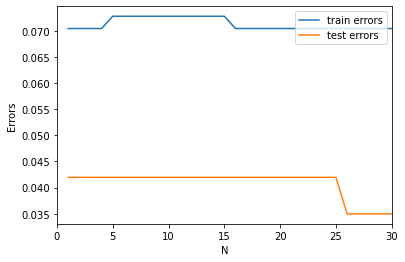

In [101]:
train_errors = []
test_errors = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for n in range(1, 31):
        mods = adaboost(X_train, y_train, n)
        train_errors.append(get_error(predict(X_train, mods), y_train))
        test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')

результаты у логистической регрессии получились хуже на трейне, чем при адаптивном бустинге на деревьях решений. Но на тесте логистическая регрессия при различных вариантах разбиения датасета часто показывает результаты лучше, чем на трейне, и лучше, чем деревья решений. Видимо, потому что модель логистический регрессии менее склонна к переобучению

<b>Домашнее задание(необязательное, повышенной сложности):</b> Реализовать специальную функцию predict для бустинга на логистической регрессии выводящую предсказания по формуле: $ Predictions=sign(Score_{bust}) $,
где sign равен единице для положительных и нулю для отрицательных значений, а $ Score_{bust}= \sum \alpha_iScore_i$.

In [100]:
def predict_2(X, models, n_classes = 2):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros(n_objects)
    
    for alpha, clf in models:

        y_pred += alpha*clf.decision_function(X)

    y_pred = np.where(y_pred>0, 1, 0)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict_2(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict_2(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 92.958
Точность алгоритма на тестовой выборке: 96.503
